In [1]:
import io
import os
import warnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

from models.model import SingleVideoPartDecomposition
from utils.get_args import get_args_jupyter
from utils.train_utils import create_dataloaders
from utils.visualization_utils import render_and_get_joints, save_video, save_gt_gen_seg

warnings.filterwarnings('ignore')

In [ ]:
config_path = "confs/spot_merge.yml"
default_config = "confs/default.yml"

args, config = get_args_jupyter(config_path, default_config)
config.dataset.batchsize = 1

train_loader = create_dataloaders(config.dataset, shuffle=True)

train_loader.dataset.n_repetition_in_epoch = 1
train_loader.dataset.color_augmentation = False
train_loader.dataset.camera_dir_augmentation = False
train_loader.dataset.background_color = 1

In [ ]:
out_dir = config.output_dir
exp_name = config.exp_name

# model
model = SingleVideoPartDecomposition(config.network_params)
model.cuda()

save_dir = os.path.join(out_dir, "result", exp_name)
model_path = os.path.join(save_dir, "snapshot_latest.pth")
if os.path.exists(model_path):
    snapshot = torch.load(model_path)
    state_dict = snapshot["model"]
    iteration = snapshot["iteration"]
    model.load_state_dict(state_dict, strict=False)
else:
    print("model is not loaded")

In [ ]:
train_loader.dataset.current_max_frame_id = train_loader.dataset.num_frames

num_frames = train_loader.dataset.num_frames


## Visualization

In [ ]:
frame_id = 0
colors = []
color_each_view = []
mask_each_view = []
segmentation_each_view = []
gt_img_each_view = []
gt_mask_each_view = []
joint_2d_each_view = []
background_each_view = []
disparity_each_view = []
child_root_each_view = []
self_root_each_view = []
for camera_id in tqdm(range(5)):
    (img, gt_mask, color, mask, disparity, segmentation, joint_2d, child_root,
     self_root, background) = render_and_get_joints(model, train_loader, frame_id, camera_id)
    color_each_view.append(color)
    mask_each_view.append(mask)
    segmentation_each_view.append(segmentation)
    gt_img_each_view.append(img)
    gt_mask_each_view.append(gt_mask)
    joint_2d_each_view.append(joint_2d)
    background_each_view.append(background)
    disparity_each_view.append(disparity)
    child_root_each_view.append(child_root)
    self_root_each_view.append(self_root)

In [ ]:


num_view = len(gt_img_each_view)
plt.figure(figsize=(6 * 6, num_view * 6))

for i in range(num_view):
    plt.subplot(num_view, 6, i * 6 + 2)
    out = color_each_view[i].cpu().numpy().transpose(1, 2, 0)
    out = out + (1 - mask_each_view[i].cpu().numpy()[:, :, None])
    out = out / 2 + 0.5
    plt.imshow(out)
    plt.title("generated")
    plt.axis("off")

    plt.subplot(num_view, 6, i * 6 + 1)
    plt.imshow(gt_img_each_view[i].cpu().numpy()[0].transpose(1, 2, 0) / 2 + 0.5)
    plt.title("gt")
    plt.axis("off")

    plt.subplot(num_view, 6, i * 6 + 3)

    out = segmentation_each_view[i].cpu().numpy().transpose(1, 2, 0) + (1 - mask_each_view[i].cpu().numpy()[:, :, None])
    out = out / 2 + 0.5
    plt.imshow(out, vmin=0, vmax=1, alpha=0.2)
    joint_2d = joint_2d_each_view[i][0, :, :]
    plt.scatter(joint_2d[:, 0], joint_2d[:, 1], s=1, c="fuchsia")
    child_root = child_root_each_view[i]
    plt.scatter(child_root[0, :, 0, :].reshape(-1), child_root[0, :, 1, :].reshape(-1), s=1)

    joint_connection = model.joint_connection.cpu().numpy()
    child_ids = model.child_ids.cpu().numpy()
    selected_child = child_root[0, joint_connection[:, 0], :, child_ids[:, 0]]
    plt.scatter(selected_child[:, 0].reshape(-1), selected_child[:, 1].reshape(-1), s=1, c="b")
    selected_child = child_root[0, joint_connection[:, 1], :, child_ids[:, 1]]
    plt.scatter(selected_child[:, 0].reshape(-1), selected_child[:, 1].reshape(-1), s=1, c="b")

    plt.title("joints")
    plt.axis("off")

    plt.subplot(num_view, 6, i * 6 + 4)

    out = segmentation_each_view[i].cpu().numpy().transpose(1, 2, 0) + (1 - mask_each_view[i].cpu().numpy()[:, :, None])
    out = out / 2 + 0.5
    plt.imshow(out, vmin=0, vmax=1, alpha=0.2)
    joint_location = (child_root[0, joint_connection[:, 0], :, child_ids[:, 0]] +
                      child_root[0, joint_connection[:, 1], :, child_ids[:, 1]]) / 2
    num_parts = model.num_parts
    for j in range(model.num_parts):
        joints = joint_location[np.where(joint_connection == j)[0]]
        if len(joints) > 1:
            color = format(j * 600000, '06x')
            for a1 in range(len(joints)):
                for a2 in range(len(joints) - 1):
                    plt.plot([joints[a1, 0], joints[a2, 0]],
                             [joints[a1, 1], joints[a2, 1]], c=f"#{color}")
        else:
            plt.plot([joints[0, 0], joint_2d[j, 0]],
                     [joints[0, 1], joint_2d[j, 1]], c="b")

        plt.text(joint_2d[j, 0], joint_2d[j, 1], j, fontsize="small")

    plt.title("structure (joint)")
    plt.axis("off")

    plt.subplot(num_view, 6, i * 6 + 5)

    out = segmentation_each_view[i].cpu().numpy().transpose(1, 2, 0) + (1 - mask_each_view[i].cpu().numpy()[:, :, None])
    out = out / 2 + 0.5
    plt.imshow(out, vmin=0, vmax=1, alpha=0.2)
    for j in range(model.num_parts):
        plt.text(joint_2d[j, 0], joint_2d[j, 1], j, fontsize="small")
        if j == model.num_parts - 1:
            break
        a1 = joint_connection[j, 0]
        a2 = joint_connection[j, 1]
        plt.plot(joint_2d[[a1, a2], 0], joint_2d[[a1, a2], 1])

    plt.title("structure (part center)")
    plt.axis("off")

## Re-pose
Re-pose the object manually. For re-posing, we need to decide `root_id`, `move_id`, and its rotation angle in `rodrigues` form. `root_id` is the part that is treated as the parent of all other parts and is fixed during re-posing. You can choose any part that is fixed during re-posing. `move_id` is the part that is moved during re-posing. `move_id` rotates with its child parts around the joint according to the angle specified in `rodrigues`. Therefore, parts that are closer to the leaf nodes must be specified first.

Once you decide them, you can create re-posing video by writing the repose-config in the following format. (e.g. `src/visualize/repose_configs/spot.yml`)
```
camera_id: 0
frame_id: 0
root: root_id
first: [ [ move_id, [ rodrigues_x, rodrigues_y, rodrigues_z ] ], [ move_id, [ rodrigues_x, rodrigues_y, rodrigues_z ] ], ... ]
second: [ [ move_id, [ rodrigues_x, rodrigues_y, rodrigues_z ] ], [ move_id, [ rodrigues_x, rodrigues_y, rodrigues_z ] ], ... ]
```
`first` defines part ids and their rotation in rodrigues form for the first quarter of the video. `second` defines part ids and their rotation in rodrigues form for the second quarter of the video.
In the other half of the video, the manipulation is done in the opposite direction of `first` and `second`.

Please refer to README.md for re-posing video generation.

In [ ]:
manipulate_pose_configs = [  # each dictionary corresponds to the re-posed images.
    {"root_id": 2,
     "motion_config": [{"move_id": 12, "rodrigues": np.array([0, -np.pi * 2 / 3, 0])}]},
    {"root_id": 2,
     "motion_config": [{"move_id": 12, "rodrigues": np.array([[0, -np.pi * 2 / 3, 0]])}, # Move the elbow earlier than the shoulder.
                       {"move_id": 8, "rodrigues": np.array([0, np.pi / 3, 0])}]},
    {"root_id": 2,
     "motion_config": [{"move_id": 12, "rodrigues": np.array([[0, -np.pi * 2 / 3, 0]])},
                       {"move_id": 8, "rodrigues": np.array([0, np.pi / 3, 0])},
                       {"move_id": 7, "rodrigues": np.array([0, -np.pi * 2 / 3, 0])}]},
    {"root_id": 2,
     "motion_config": [{"move_id": 12, "rodrigues": np.array([[0, -np.pi * 2 / 3, 0]])},
                       {"move_id": 8, "rodrigues": np.array([0, np.pi / 3, 0])},
                       {"move_id": 7, "rodrigues": np.array([[0, -np.pi * 2 / 3, 0]])},
                       {"move_id": 11, "rodrigues": np.array([0, np.pi / 3, 0])}]},
]

In [8]:
frame_id = 0
camera_id = 0
colors = []
color_each_view = []
mask_each_view = []
segmentation_each_view = []
gt_img_each_view = []
gt_mask_each_view = []
joint_2d_each_view = []
background_each_view = []
disparity_each_view = []
child_root_each_view = []
self_root_each_view = []

for i in tqdm(range(len(manipulate_pose_configs))):
    (img, gt_mask, color, mask, disparity, segmentation, joint_2d, child_root, self_root,
     background) = render_and_get_joints(model, train_loader,
                                         frame_id, camera_id, manipulate_pose_configs[i])
    color_each_view.append(color)
    mask_each_view.append(mask)
    segmentation_each_view.append(segmentation)
    gt_img_each_view.append(img)
    gt_mask_each_view.append(gt_mask)
    joint_2d_each_view.append(joint_2d)
    background_each_view.append(background)
    disparity_each_view.append(disparity)
    child_root_each_view.append(child_root)
    self_root_each_view.append(self_root)

100%|██████████| 4/4 [00:07<00:00,  1.97s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


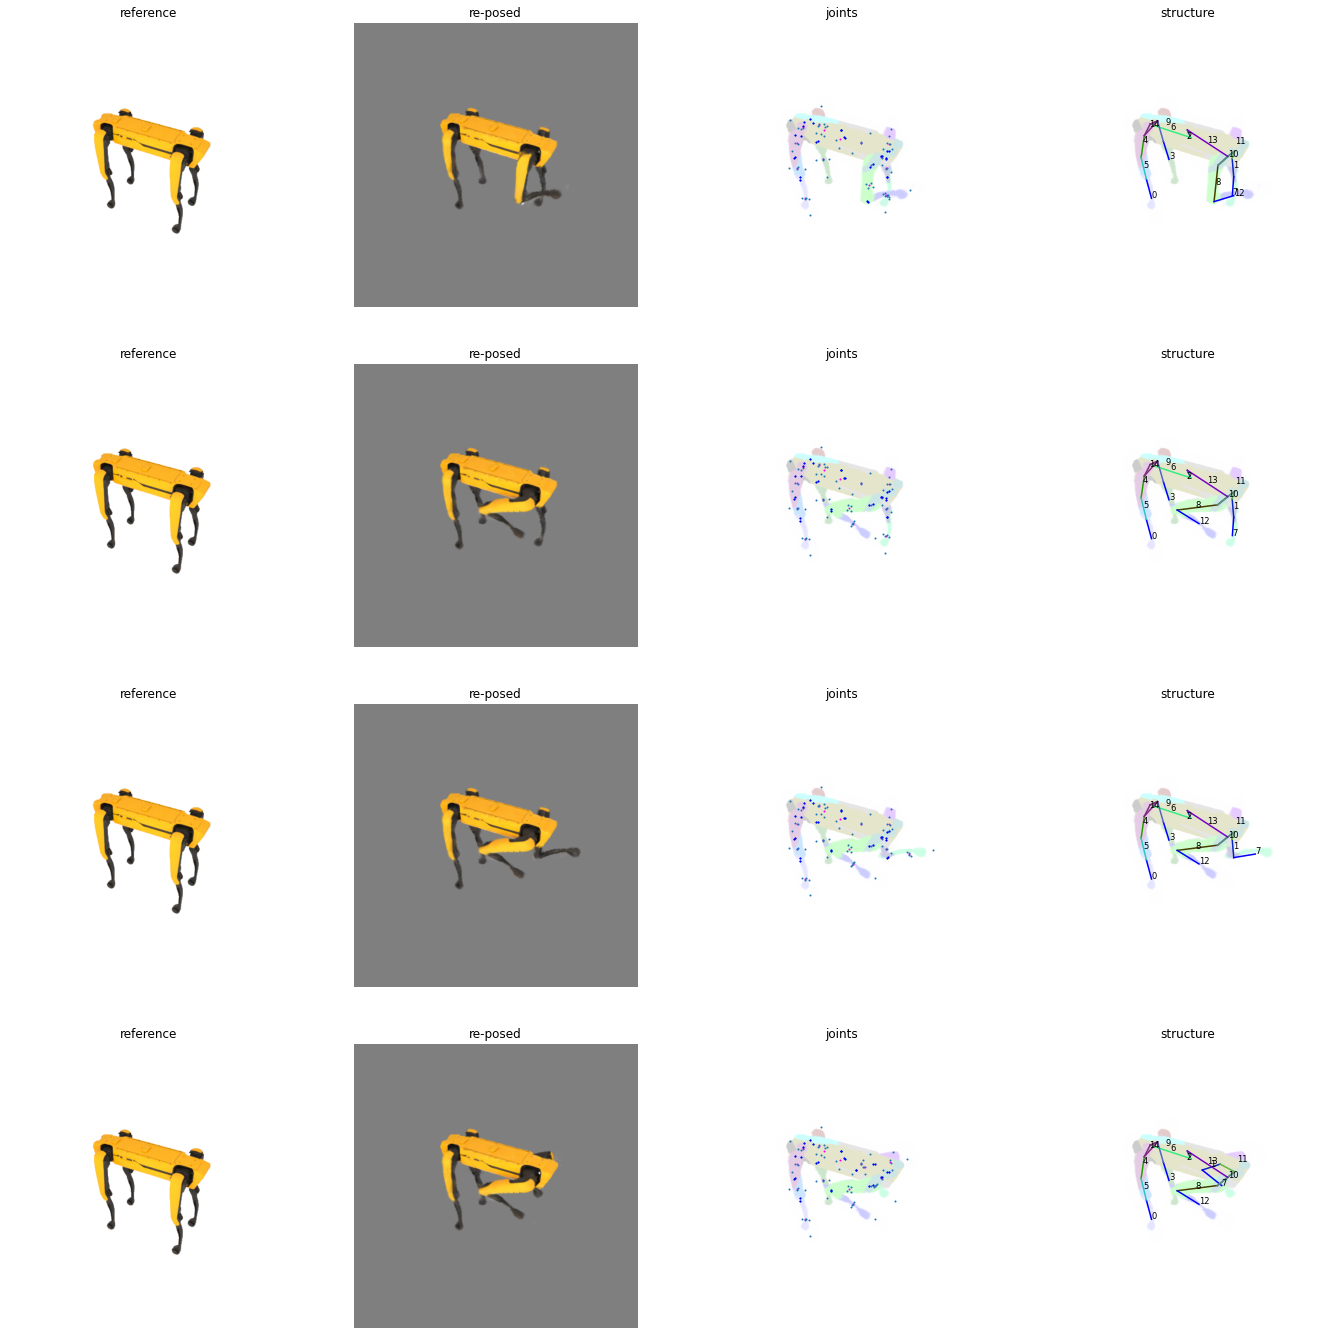

In [9]:


num_view = len(gt_img_each_view)
plt.figure(figsize=(5 * 6, num_view * 6))

for i in range(len(manipulate_pose_configs)):
    plt.subplot(num_view, 5, i * 5 + 2)
    out = color_each_view[i].cpu().numpy().transpose(1, 2, 0)
    out = out / 2 + 0.5
    plt.imshow(out)
    plt.title("re-posed")
    plt.axis("off")

    plt.subplot(num_view, 5, i * 5 + 1)
    plt.imshow(gt_img_each_view[i].cpu().numpy()[0].transpose(1, 2, 0) / 2 + 0.5)
    plt.title("reference")
    plt.axis("off")

    plt.subplot(num_view, 5, i * 5 + 3)

    out = segmentation_each_view[i].cpu().numpy().transpose(1, 2, 0) + (1 - mask_each_view[i].cpu().numpy()[:, :, None])
    out = out / 2 + 0.5
    plt.imshow(out, vmin=0, vmax=1, alpha=0.2)
    joint_2d = joint_2d_each_view[i][0, :, :]
    plt.scatter(joint_2d[:, 0], joint_2d[:, 1], s=1, c="fuchsia")
    child_root = child_root_each_view[i]
    plt.scatter(child_root[0, :, 0, :].reshape(-1), child_root[0, :, 1, :].reshape(-1), s=1)

    joint_connection = model.joint_connection.cpu().numpy()
    child_ids = model.child_ids.cpu().numpy()
    selected_child = child_root[0, joint_connection[:, 0], :, child_ids[:, 0]]
    plt.scatter(selected_child[:, 0].reshape(-1), selected_child[:, 1].reshape(-1), s=1, c="b")
    selected_child = child_root[0, joint_connection[:, 1], :, child_ids[:, 1]]
    plt.scatter(selected_child[:, 0].reshape(-1), selected_child[:, 1].reshape(-1), s=1, c="b")

    plt.title("joints")
    plt.axis("off")

    plt.subplot(num_view, 5, i * 5 + 4)

    out = segmentation_each_view[i].cpu().numpy().transpose(1, 2, 0) + (1 - mask_each_view[i].cpu().numpy()[:, :, None])
    out = out / 2 + 0.5
    plt.imshow(out, vmin=0, vmax=1, alpha=0.2)
    joint_location = (child_root[0, joint_connection[:, 0], :, child_ids[:, 0]] +
                      child_root[0, joint_connection[:, 1], :, child_ids[:, 1]]) / 2
    num_parts = model.num_parts
    for j in range(model.num_parts):
        joints = joint_location[np.where(joint_connection == j)[0]]
        if len(joints) > 1:
            color = format(j * 600000, '06x')
            for a1 in range(len(joints)):
                for a2 in range(len(joints) - 1):
                    plt.plot([joints[a1, 0], joints[a2, 0]],
                             [joints[a1, 1], joints[a2, 1]], c=f"#{color}")
        else:
            plt.plot([joints[0, 0], joint_2d[j, 0]],
                     [joints[0, 1], joint_2d[j, 1]], c="b")

        plt.text(joint_2d[j, 0], joint_2d[j, 1], j, fontsize="small")
    plt.title("structure")
    plt.axis("off")


## Tracking

In [10]:
with torch.no_grad():
    frame_id = torch.arange(config.dataset.num_frames, dtype=torch.float, device="cuda")
    trajectory = model.joint_trajectory(frame_id)

rotation, translation = trajectory

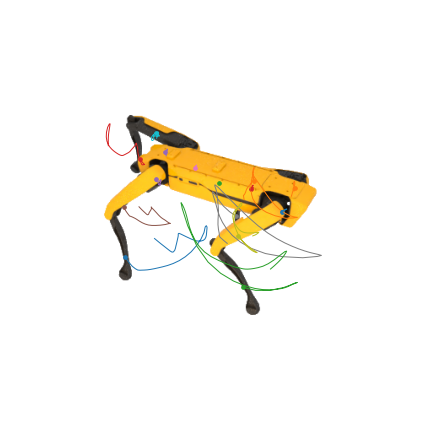

In [11]:


num_frames = train_loader.dataset.num_frames // train_loader.dataset.thin_out_interval
frame_interval = 2
initial_frame = config.train_setting.frame_schedule.incremental.initial_frame
start = config.train_setting.frame_schedule.incremental.start
incremental_period = config.train_setting.frame_schedule.incremental.incremental_period
frames = int(((iteration - start) / incremental_period * num_frames + initial_frame) * 1 / frame_interval) - 1
frames = min(frames, num_frames // frame_interval)
frames = 80
camera_id = 0
trans_numpy = translation.cpu().numpy()

minibatch = train_loader.dataset[camera_id * num_frames]

intrinsic = minibatch["camera_intrinsic"]
camera_rotation = minibatch["camera_rotation"]
camera_translation = minibatch["camera_translation"]

# to camera coordinate
trans_numpy = np.matmul(camera_rotation, trans_numpy) + camera_translation
# to image coordinate
trans_numpy = np.matmul(intrinsic, trans_numpy)
trans_numpy = trans_numpy[:, :, :2] / trans_numpy[:, :, 2:]
num_parts = trans_numpy.shape[1]


def run(fr):
    fr = fr * frame_interval
    plt.clf()
    minibatch = train_loader.dataset[fr + camera_id * num_frames]
    img = minibatch["img"]

    plt.imshow(img.transpose(1, 2, 0) / 2 + 0.5)
    for i in range(num_parts):
        plt.scatter(trans_numpy[fr, i, 0, 0], trans_numpy[fr, i, 1, 0], s=13)
    for i in range(num_parts):
        plt.plot(trans_numpy[max(0, fr - 60):fr + 1, i, 0, 0], trans_numpy[max(0, fr - 60):fr + 1, i, 1, 0],
                 linewidth=1)
    plt.axis("off")

    plt.gca().set_aspect('equal')
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=150)
    enc = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    dst = cv2.imdecode(enc, 1)[:, :, ::-1]

    return dst


fig = plt.figure(figsize=(6, 6))
video = np.array([run(fr) for fr in range(frames)])
save_video(video, os.path.join(save_dir, f'tracking_{camera_id}.mp4'))
save_gt_gen_seg(video, os.path.join(save_dir, f'tracking_{camera_id}'))